# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 30,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 10000
}
causal_hyperparams = {
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,   
}

SEED = 1
NUM_ITER = 20
NUM_SAMPLES = 10000
TRUE_PARAMS = {'ate': 1, 'const': 0, 'scale': 1}
CAUSAL_PARAMS = [0, 1]

In [2]:
def run_outcome_regression(data):
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X']]), columns=['X', 'Y'])
    df['X'] = data['X']
    df['Y'] = data['Y']
    X_vars = df['X']
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

In [42]:
CAUSAL_PARAMS = [0, 1]
SEED = 123
Z_d, Z_c, X, Y = causl_py.generate_mixed_samples(N=10000, causal_params=CAUSAL_PARAMS, seed=SEED).values()

uz_samples = causl_py.generate_uz_samples(Z_cont=Z_c, use_marginal_flow=False)

ff, _ = train_frugal_flow(
    key=jr.PRNGKey(1),
    y=Y,
    u_z=uz_samples['uz_cont'],
    condition=X,
    **hyperparams_dict,
    causal_model_args={'ate': 0, 'const': 1, 'scale': 1}
)

causal_margin = ff.bijection.bijections[-1].bijection.bijections[0]

print(causal_margin.ate)
print(causal_margin.const)

  1%|▋                                                                                                | 73/10000 [00:29<1:06:43,  2.48it/s, train=1.3447169868307167, val=1.3938271238653503 (Max patience reached)]

0.7987217431294308
0.1895250611507498


## Checking for the Causal Effect

### Gaussians

#### Frugal Flow

In [3]:
gaussian_covariates_results = causl_py.run_simulations(
    causl_py.generate_gaussian_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▉                                                                                              | 95/10000 [00:40<1:11:12,  2.32it/s, train=-1.6403389912718698, val=-1.5463473124980402 (Max patience reached)]


In [4]:
gaussian_covariates_results

,ate,const,scale
0,1.050382,-0.064905,1.003842
1,1.003069,0.006152,1.022358
2,1.016189,-0.001576,1.026638
3,1.007937,-0.016758,1.014794
4,1.001513,0.025818,1.039247
5,1.005853,-0.013656,1.014822
6,1.002561,0.013189,1.021326
7,1.039061,-0.039400,1.023173
8,1.019458,-0.019956,1.017204
9,1.034972,-0.022593,1.024947


In [5]:
display(gaussian_covariates_results.mean())
display(gaussian_covariates_results.std())

ate      1.008907
const   -0.004796
scale    1.023406
dtype: float64

ate      0.018395
const    0.022177
scale    0.010920
dtype: float64

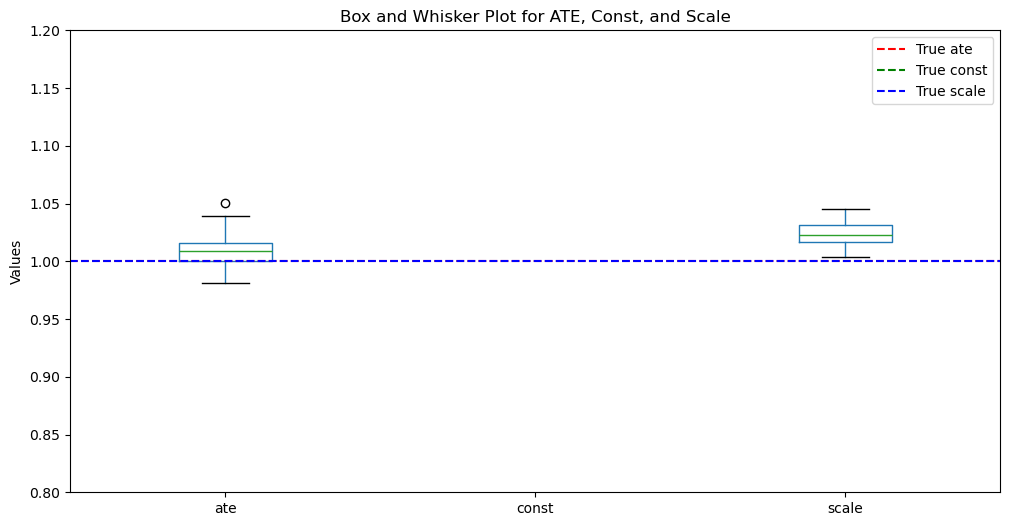

In [6]:
plt.figure(figsize=(12, 6))

# Boxplot
box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

#### Outcome Regression

In [7]:
gaussian_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_gaussian_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    gaussian_coeffs['ate'].append(coeff_X)
    gaussian_coeffs['const'].append(coeff_const)
gaussian_outcome_coeffs = pd.DataFrame.from_dict(gaussian_coeffs)
gaussian_outcome_coeffs

,ate,const
0,2.031925,-0.725165
1,2.020742,-0.721228
2,2.041646,-0.727061
3,2.018806,-0.706405
4,1.989711,-0.705807
5,2.051059,-0.733319
6,1.990568,-0.711508
7,2.007042,-0.702561
8,2.023868,-0.734764
9,2.069247,-0.750604


In [8]:
print(gaussian_outcome_coeffs.mean())
print(gaussian_outcome_coeffs.std())

ate      2.017993
const   -0.715322
dtype: float64
ate      0.020903
const    0.014573
dtype: float64


### Mixed Gaussian and Gamma Outcomes

In [9]:
Z_disc, Z_cont, X, Y = causl_py.generate_mixed_samples(10000, CAUSAL_PARAMS, 0).values()

In [10]:
uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)

In [11]:
uz_disc_samples = uz_samples['uz_disc']
uz_cont_samples = uz_samples['uz_cont']

In [12]:
frugal_flow, losses = causl_py.train_frugal_flow(
    key=jr.PRNGKey(0),
    y=Y,
    u_z=uz_cont_samples,
    condition=X,
    **hyperparams_dict,
    causal_model='gaussian',
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  1%|▋                                                                                                 | 72/10000 [00:31<1:13:13,  2.26it/s, train=1.3118372802965774, val=1.394872411050176 (Max patience reached)]


In [13]:
causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]

In [14]:
causal_margin.ate

Array(0.9003078, dtype=float64)

In [15]:
causal_margin.const

Array(0.12778634, dtype=float64)

In [16]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▌                                                                                                  | 56/10000 [00:23<1:08:46,  2.41it/s, train=1.341053858542203, val=1.450241172700236 (Max patience reached)]


In [17]:
continous_covariates_results

,ate,const,scale
0,0.952246,0.014496,0.999720
1,0.990709,0.015249,0.984676
2,0.870514,0.139311,1.019283
3,0.847649,0.147494,1.008410
4,0.951182,0.035122,1.002024
5,0.993555,-0.001487,1.012916
6,0.999641,0.013315,0.992722
7,0.887139,0.097139,1.026425
8,0.885389,0.094615,1.014569
9,1.064989,-0.045876,1.005231


In [18]:
print(continous_covariates_results.mean())
print(continous_covariates_results.std())

ate      0.885977
const    0.105599
scale    1.004996
dtype: float64
ate      0.144997
const    0.144496
scale    0.010888
dtype: float64


#### Outcome Regression

In [19]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_mixed_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.276950,-0.261755
1,1.119173,-0.108051
2,1.124865,-0.108181
3,1.159565,-0.135480
4,1.166381,-0.160719
5,1.190880,-0.188119
6,1.183388,-0.180212
7,1.064854,-0.062930
8,1.179242,-0.181402
9,1.188144,-0.186739


In [20]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.179334
const   -0.172884
dtype: float64
ate      0.060624
const    0.062676
dtype: float64


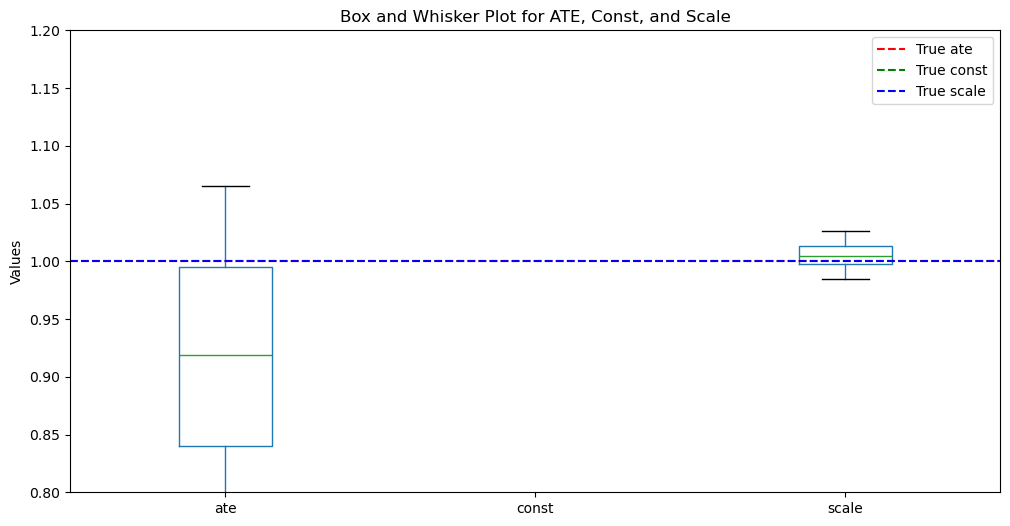

In [21]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Small)

In [22]:
discrete_small_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▌                                                                                                | 61/10000 [00:25<1:10:10,  2.36it/s, train=1.3406504872717944, val=1.4758852019762203 (Max patience reached)]


In [23]:
discrete_small_covariates_results

,ate,const,scale
0,0.987726,-0.003969,0.987821
1,0.954646,0.012157,1.013235
2,1.025338,0.003429,1.007263
3,1.004720,-0.011882,0.987635
4,0.979794,-0.023487,1.018832
5,1.011158,-0.002786,1.004987
6,1.001832,-0.010441,0.986434
7,1.028097,-0.032411,0.995556
8,0.994869,-0.006614,0.989540
9,0.908805,0.046090,1.006022


In [24]:
print(discrete_small_covariates_results.mean())
print(discrete_small_covariates_results.std())

ate      0.990891
const   -0.001790
scale    1.001252
dtype: float64
ate      0.031962
const    0.019232
scale    0.010550
dtype: float64


#### Outcome Regression

In [25]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.030409,-0.010012
1,1.009222,-0.006195
2,0.966494,0.005907
3,1.014426,-0.005735
4,1.017109,-0.009507
5,1.023951,-0.020754
6,1.029366,-0.019614
7,1.024277,-0.024517
8,1.029593,-0.016401
9,1.027913,-0.016856


In [26]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.013639
const   -0.010086
dtype: float64
ate      0.019178
const    0.010328
dtype: float64


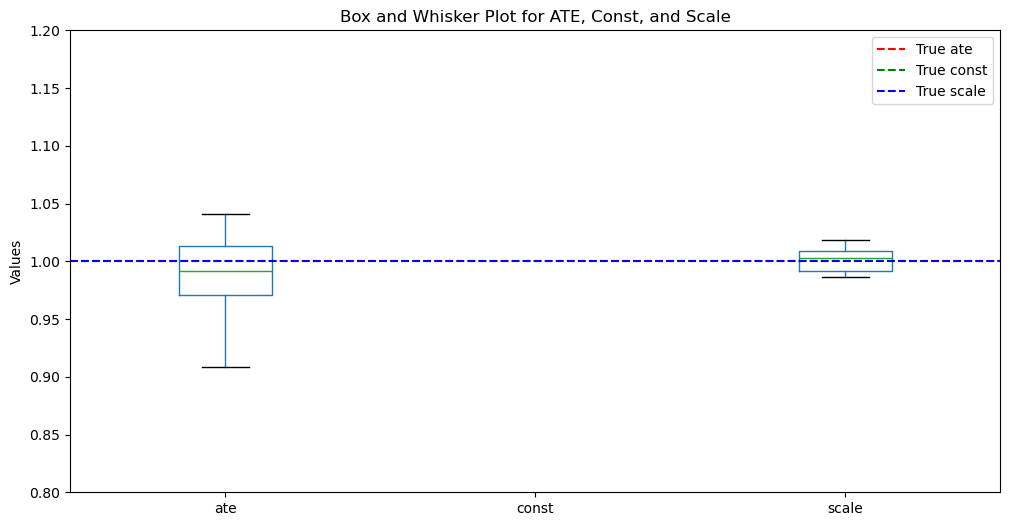

In [27]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_small_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large)

In [28]:
discrete_big_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▋                                                                                                | 69/10000 [00:52<2:04:56,  1.32it/s, train=0.5336190009108509, val=1.0447162255793547 (Max patience reached)]


In [29]:
discrete_big_covariates_results

,ate,const,scale
0,0.889362,0.084961,0.989383
1,0.874020,0.068540,0.998464
2,0.836236,0.062407,1.021417
3,0.867363,0.086069,1.004870
4,0.901816,0.057294,1.017551
5,0.822429,0.099726,1.005909
6,0.845096,0.086302,1.009502
7,0.816257,0.098840,0.998290
8,0.800889,0.095491,1.021518
9,0.796356,0.107300,1.000433


In [30]:
print(discrete_big_covariates_results.mean())
print(discrete_big_covariates_results.std())

ate      0.828171
const    0.098060
scale    1.004824
dtype: float64
ate      0.047797
const    0.028686
scale    0.011308
dtype: float64


#### Outcome Regression

In [31]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,0.850585,0.085703
1,0.870645,0.092082
2,0.873446,0.077146
3,0.842214,0.073278
4,0.897348,0.050728
5,0.901161,0.057488
6,0.868855,0.083582
7,0.861545,0.083067
8,0.837722,0.082412
9,0.838780,0.083334


In [32]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      0.86810
const    0.07473
dtype: float64
ate      0.020928
const    0.013655
dtype: float64


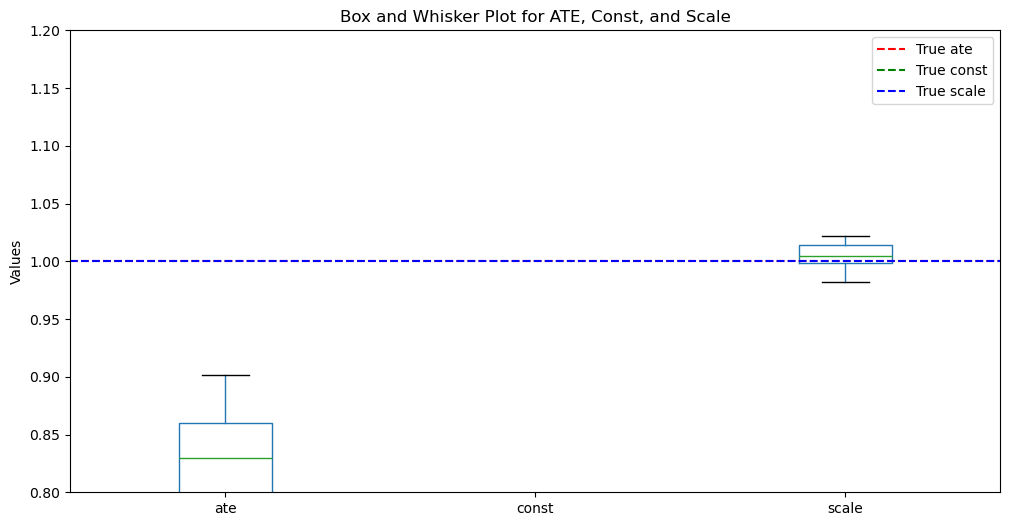

In [33]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_big_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large and Sparse)

In [34]:
discrete_sparse_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples_sparse, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▌                                                                                                 | 59/10000 [00:45<2:09:01,  1.28it/s, train=1.3038973771908804, val=1.496941938515196 (Max patience reached)]


In [35]:
discrete_sparse_covariates_results

,ate,const,scale
0,1.021410,0.004963,0.982065
1,1.020263,0.008908,0.986258
2,0.960681,-0.007203,0.989616
3,0.953924,0.020004,1.005042
4,0.990894,0.011029,0.991352
5,0.983967,0.005706,0.996097
6,0.948182,0.018799,1.015675
7,0.929348,0.024689,0.985976
8,0.999051,-0.003458,0.997626
9,0.984501,-0.001038,0.988018


In [36]:
print(discrete_sparse_covariates_results.mean())
print(discrete_sparse_covariates_results.std())

ate      0.972456
const    0.013562
scale    0.996585
dtype: float64
ate      0.039188
const    0.032729
scale    0.013246
dtype: float64


#### Outcome Regression

In [37]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,0.850585,0.085703
1,0.870645,0.092082
2,0.873446,0.077146
3,0.842214,0.073278
4,0.897348,0.050728
5,0.901161,0.057488
6,0.868855,0.083582
7,0.861545,0.083067
8,0.837722,0.082412
9,0.838780,0.083334


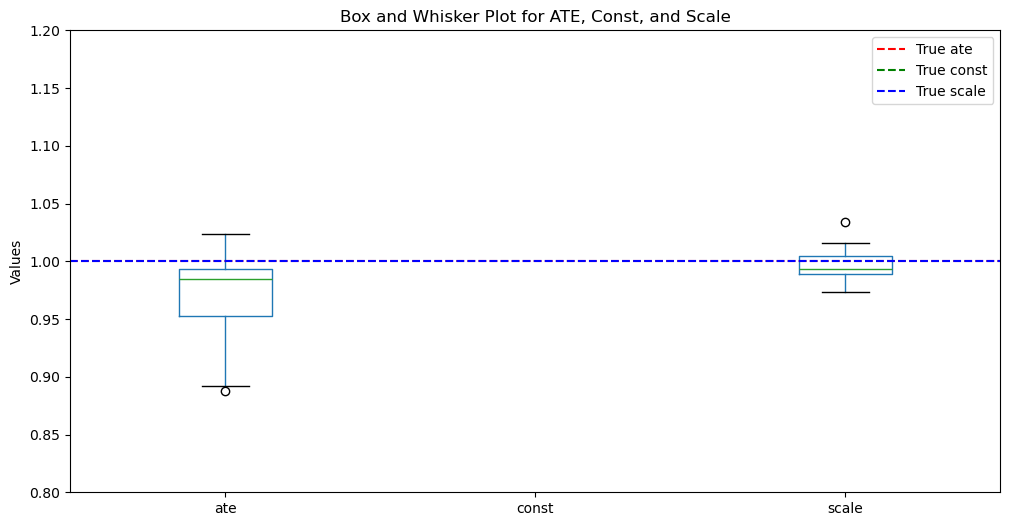

In [38]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_sparse_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()